In [1]:
!pip install kaggle
!pip install tensorflow
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install pandas

In [2]:
from google.colab import files
files.upload() # Pilih file kaggle.json yang sudah di download dari akun kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rifdana","key":"a7a8e94279839829e2bad5b528331ee4"}'}

In [3]:
# Memindahkan kaggle.json ke direktori yang sesuai
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dataset dari Kaggle
!kaggle datasets download -d rifdana/dataset-katarak-sinilis --force

# Mengekstrak dataset
!unzip dataset-katarak-sinilis.zip

Dataset URL: https://www.kaggle.com/datasets/rifdana/dataset-katarak-sinilis
License(s): CC-BY-SA-4.0
 52% 17.0M/32.7M [00:00<00:00, 34.3MB/s]
100% 32.7M/32.7M [00:00<00:00, 59.6MB/s]
Archive:  dataset-katarak-sinilis.zip
  inflating: Dataset Katarak/test/Immature/aug_0_1010_jpeg.rf.299bb9938c97ea011d6f645b986a24f6.jpg  
  inflating: Dataset Katarak/test/Immature/aug_0_1012_jpeg.rf.37e31f96a29ce5a68d23deab1b128f4e.jpg  
  inflating: Dataset Katarak/test/Immature/aug_0_1156_jpeg.rf.ff8950ee5178b7620b73485b6719fb41.jpg  
  inflating: Dataset Katarak/test/Immature/aug_0_1166_jpeg.rf.6125272d377e504352daecbabb368032.jpg  
  inflating: Dataset Katarak/test/Immature/aug_0_1327_jpeg.rf.5e4686fa4f26a4d0e0471a2fbab8e7ff.jpg  
  inflating: Dataset Katarak/test/Immature/aug_0_1341_jpeg.rf.dc46fc27a824e3a4631f69d054e183c3.jpg  
  inflating: Dataset Katarak/test/Immature/aug_0_1349_jpeg.rf.bef9a585258dc4b8b6e9af6f399127b0.jpg  
  inflating: Dataset Katarak/test/Immature/aug_0_1446_jpeg.rf.b8b1c612d

In [4]:
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

# Define your parameter ranges
epochs_list = [50, 100, 150] # define epochs variations to be examined
dropout_list = [0.3, 0.4] # define dropout variations to be examined
img_size_list = [(128, 128)] # define image size variations to be examined
augmentation_list = [True, False] # define augmentation variations to be examined

# Create combinations of parameters
parameter_combinations = list(itertools.product(epochs_list, dropout_list, img_size_list, augmentation_list))

# Define global variables
data_dir = 'Dataset Katarak/train'
BATCH_SIZE = 64  # adjustable

# Function to create and compile the model
def create_model(dropout_rate, img_size):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    return model

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        val_true = np.argmax(val_labels, axis=1)
        f1 = f1_score(val_true, val_pred, average='weighted')
        self.f1_scores.append(f1)
        print(f"\nEpoch {epoch + 1}: F1 Score = {f1}")

In [5]:
# Function to train and evaluate the model
def train_and_evaluate(epochs, dropout, img_size, augmentation):
    # Define data augmentation options
    if augmentation:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )

    # Generators for training and validation
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # Create and compile the model
    model = create_model(dropout, img_size)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Prepare validation data for callback
    val_data = np.concatenate([validation_generator[i][0] for i in range(len(validation_generator))])
    val_labels = np.concatenate([validation_generator[i][1] for i in range(len(validation_generator))])

    # Initialize F1 score callback
    f1_callback = F1ScoreCallback(validation_data=(val_data, val_labels))

    try:
        # Train the model
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // BATCH_SIZE,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // BATCH_SIZE,
            epochs=epochs,
            callbacks=[f1_callback]
        )

        # Collect per epoch data
        epoch_data = {
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'f1': f1_callback.f1_scores
        }

        # Compute average metrics
        avg_accuracy = np.mean(history.history['val_accuracy'])
        avg_loss = np.mean(history.history['val_loss'])
        avg_f1 = np.mean(f1_callback.f1_scores)
    except Exception as e:
        print(f"Training failed with error: {e}")
        avg_accuracy, avg_loss, avg_f1, epoch_data = None, None, None, {}

    return avg_accuracy, avg_loss, avg_f1, epoch_data

# List to collect the results
results = []
epoch_results = []

In [6]:
# Run experiments
for i, (epochs, dropout, img_size, augmentation) in enumerate(parameter_combinations):
    try:
        avg_accuracy, avg_loss, avg_f1, epoch_data = train_and_evaluate(epochs, dropout, img_size, augmentation)
        if avg_accuracy is not None:  # Only append results if training was successful
            results.append({
                'experiment': i + 1,
                'augmentation': 'yes' if augmentation else 'no',
                'epochs': epochs,
                'img_size': f"{img_size[0]}x{img_size[1]}",
                'dropout': dropout,
                'avg_accuracy': avg_accuracy,
                'avg_loss': avg_loss,
                'avg_f1_score': avg_f1
            })
            epoch_results.append(epoch_data)
    except Exception as e:
        print(f"Experiment {i + 1} failed with error: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 28ms/step

Epoch 9: F1 Score = 0.6638940189871412
30/30 [==============================] - 13s 419ms/step - loss: 0.7115 - accuracy: 0.6822 - val_loss: 0.7140 - val_accuracy: 0.6652
Epoch 10/100
16/16 [==============================] - 0s 28ms/step

Epoch 10: F1 Score = 0.6732085334249296
30/30 [==============================] - 13s 426ms/step - loss: 0.6569 - accuracy: 0.7122 - val_loss: 0.6576 - val_accuracy: 0.6987
Epoch 11/100
16/16 [==============================] - 0s 26ms/step

Epoch 11: F1 Score = 0.7335887571451988
30/30 [==============================] - 13s 422ms/step - loss: 0.6443 - accuracy: 0.7132 - val_loss: 0.5974 - val_accuracy: 0.7522
Epoch 12/100
16/16 [==============================] - 0s 28ms/step

Epoch 12: F1 Score = 0.7439402349059409
30/30 [==============================] - 13s 422ms/step - loss: 0.6331 - accuracy: 0.7285 - val_loss: 0.6054 - val_accuracy: 0.7500
Epo

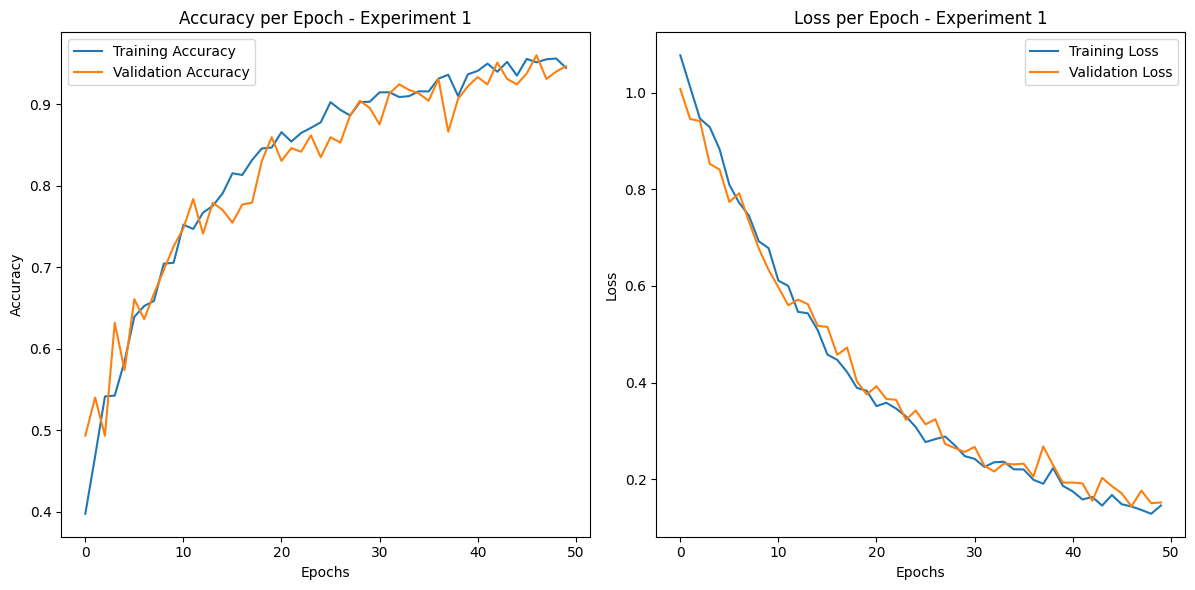

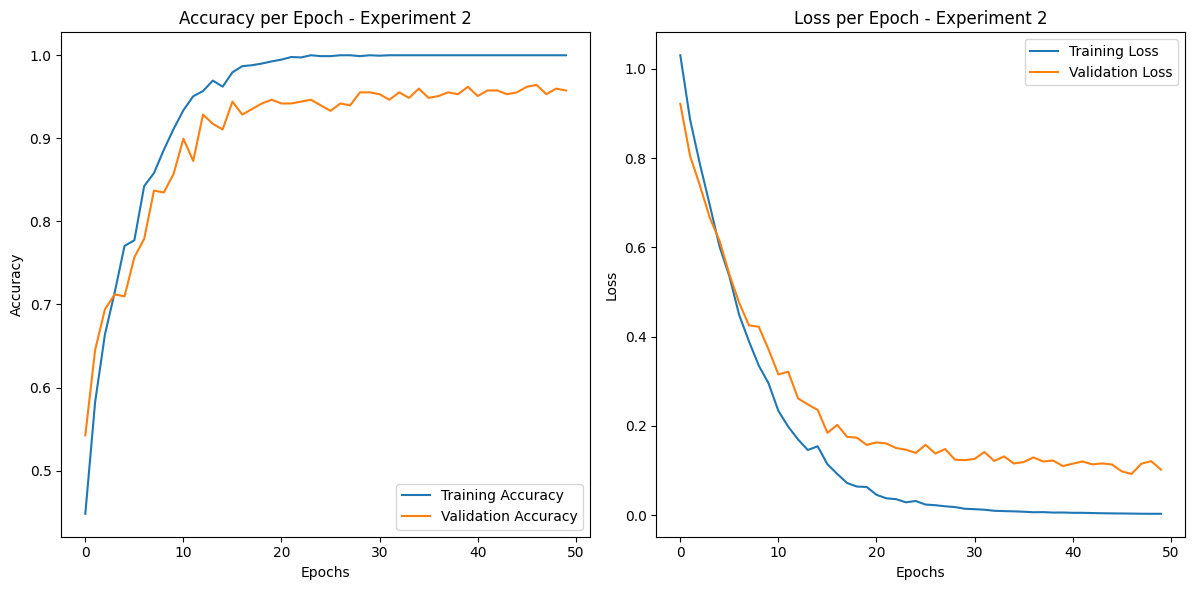

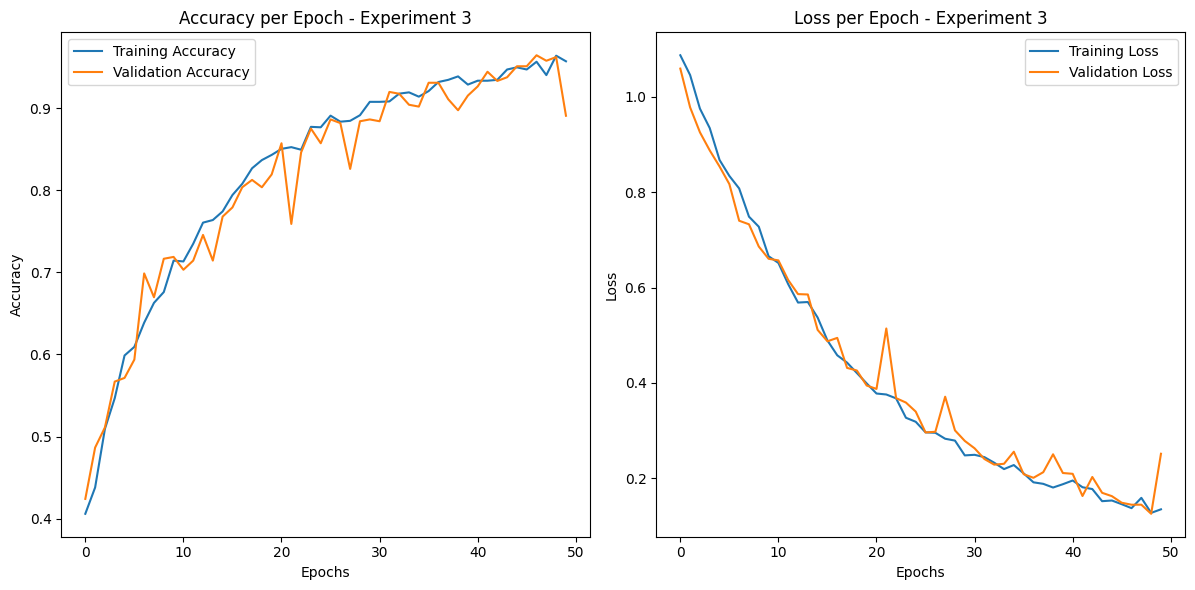

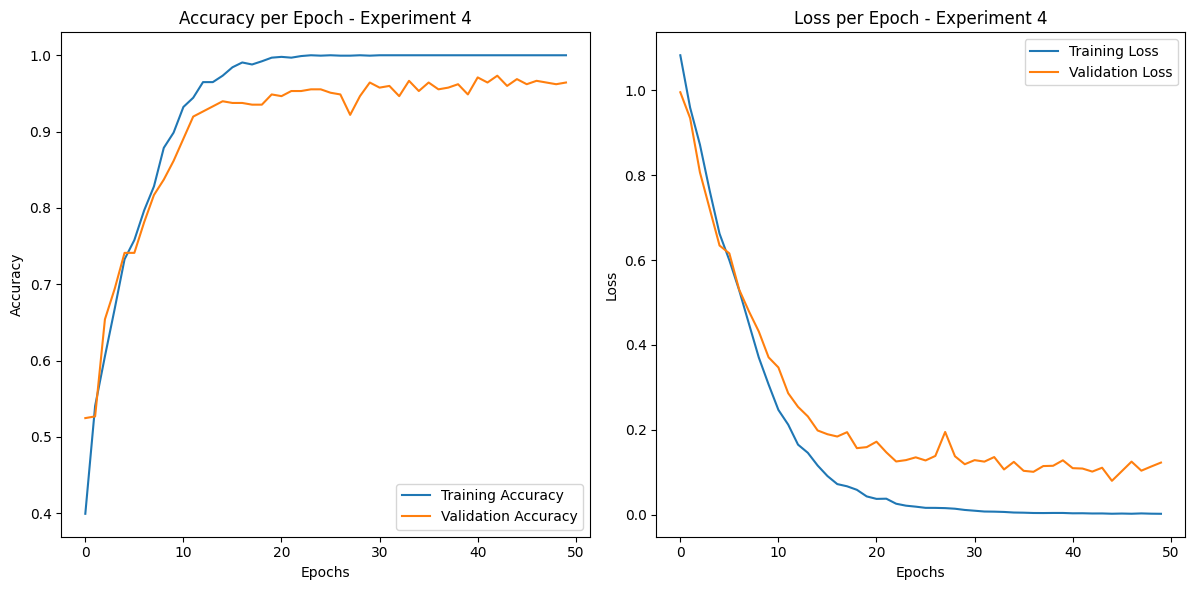

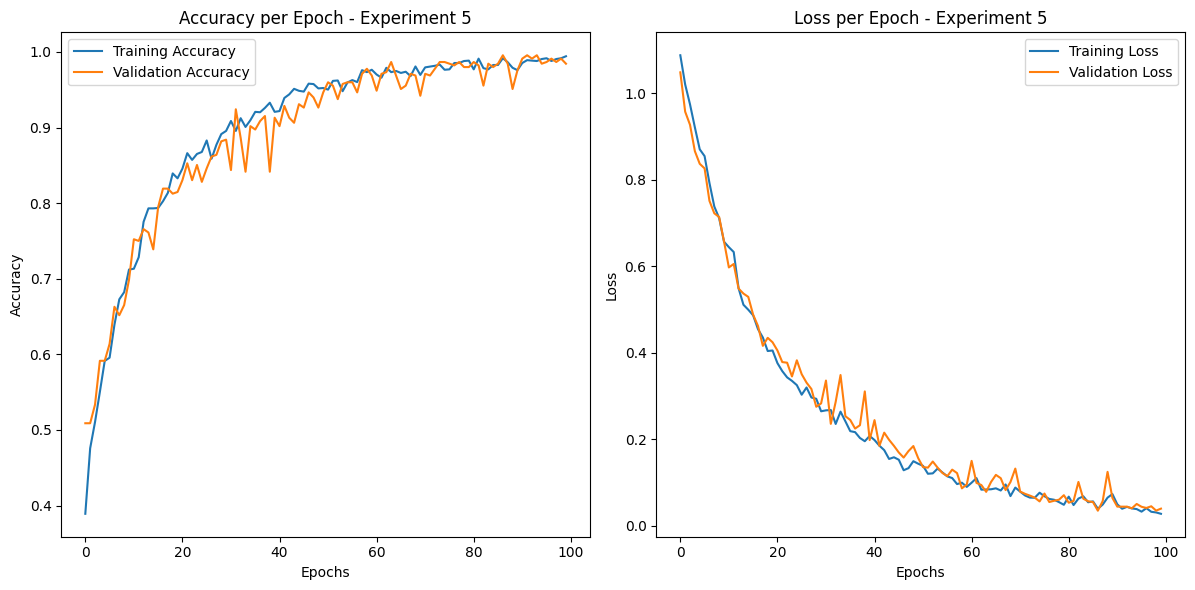

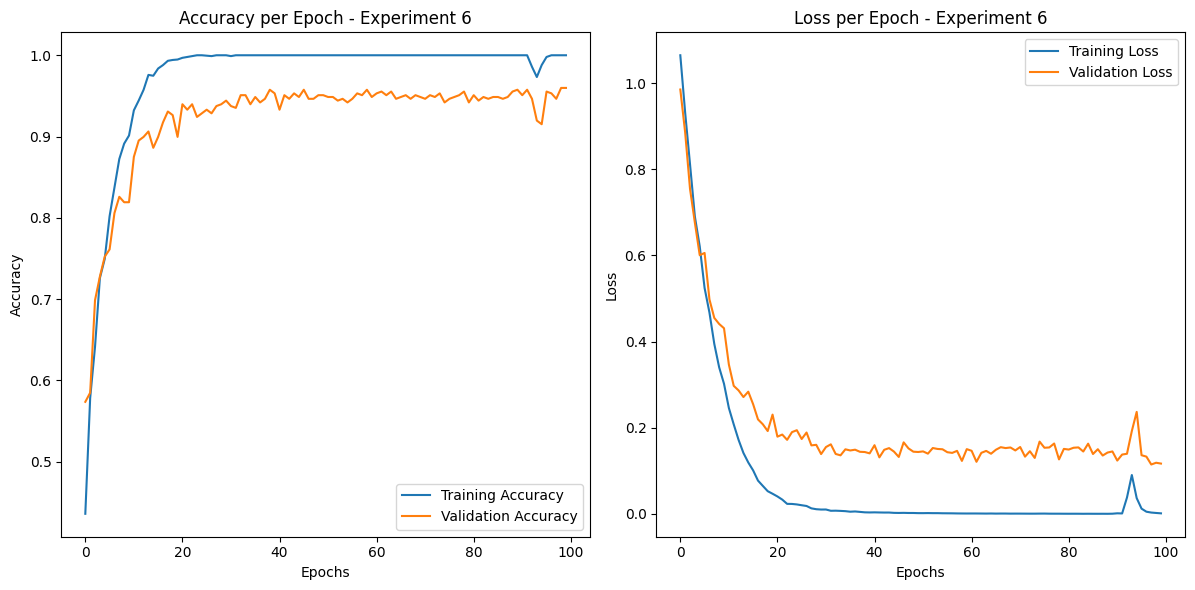

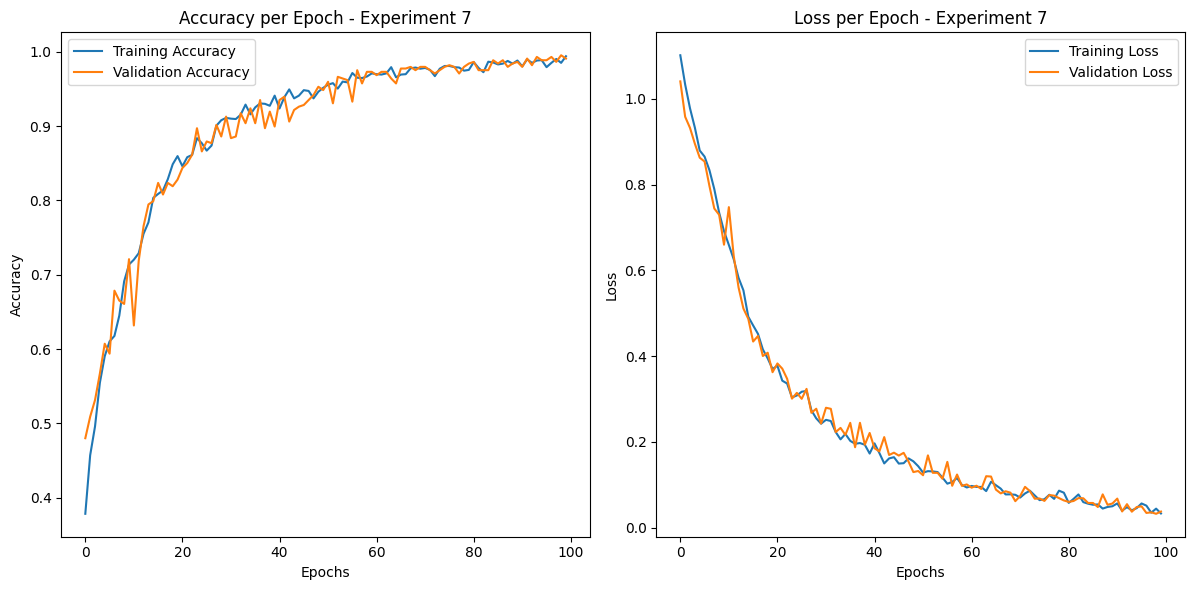

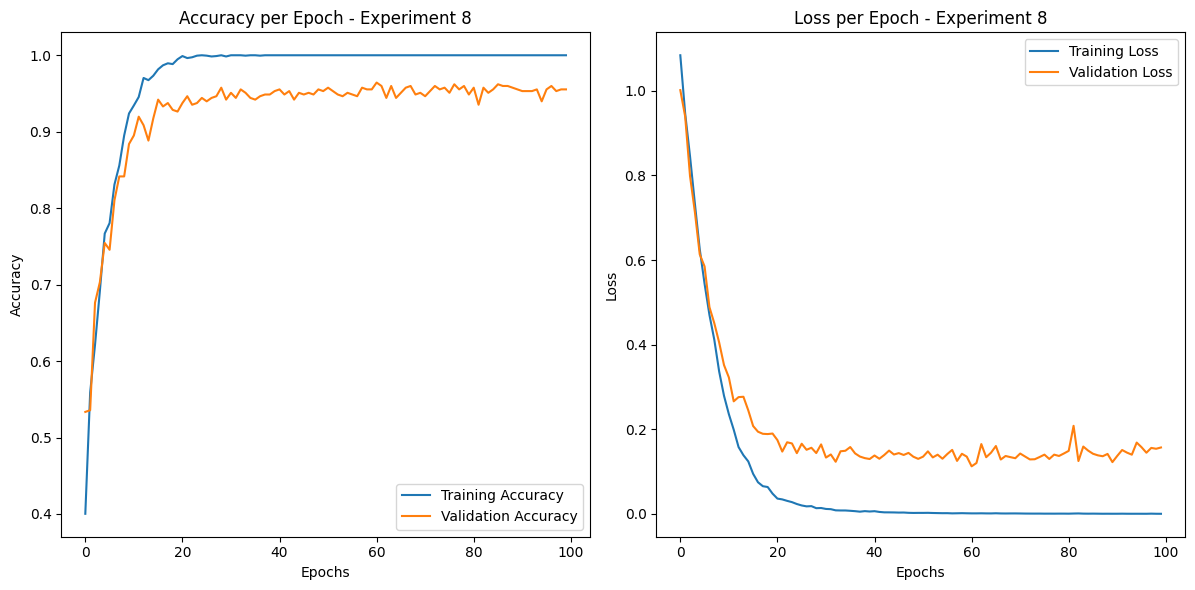

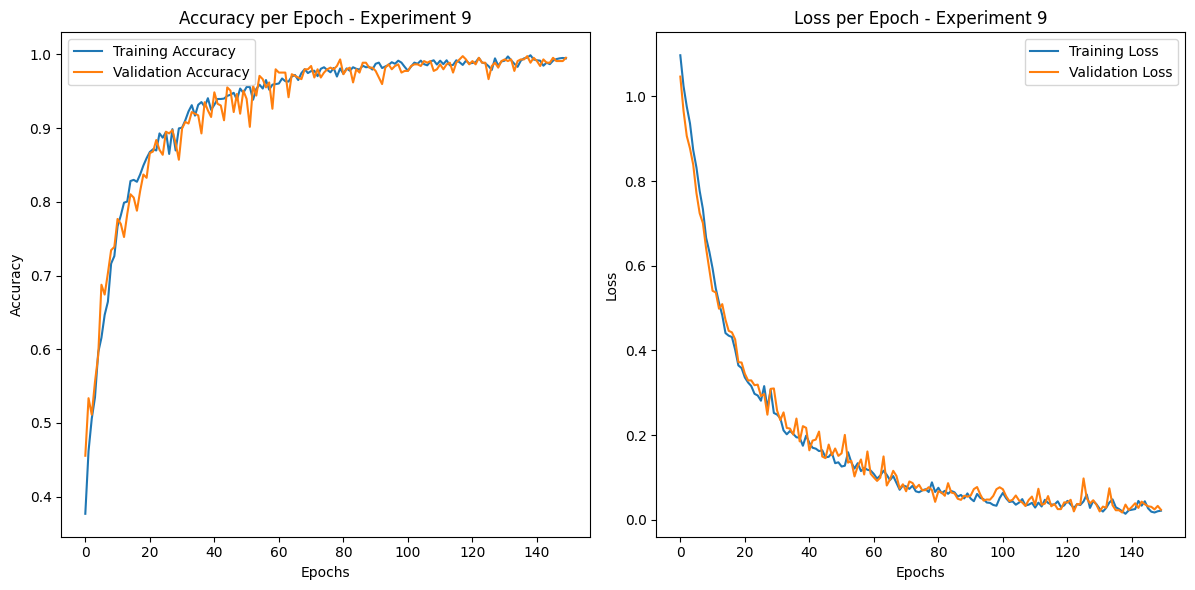

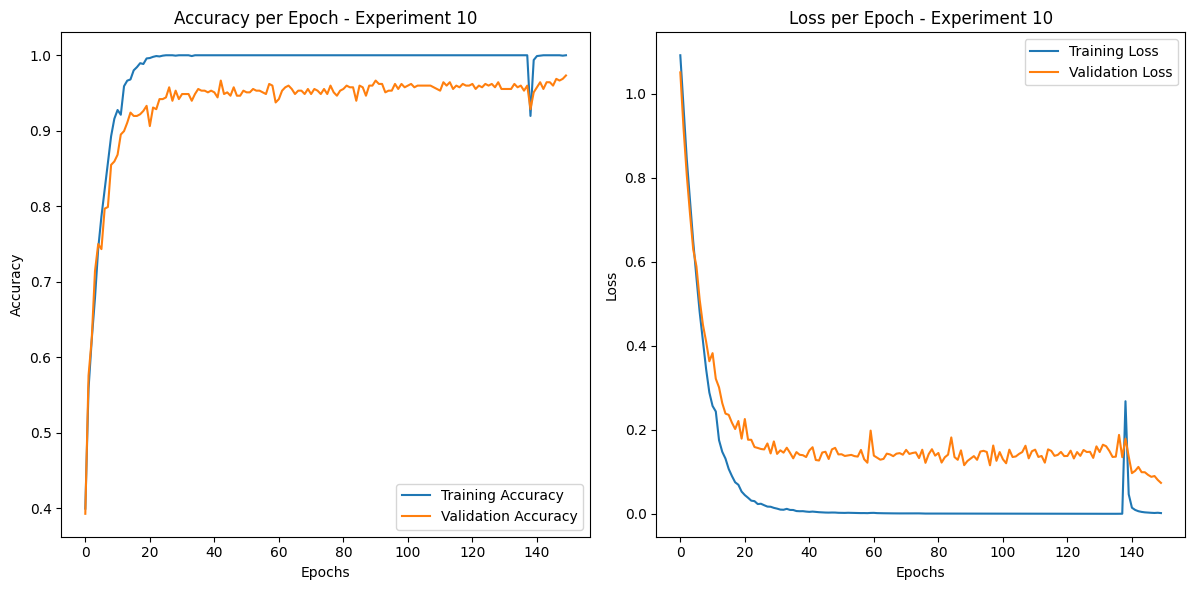

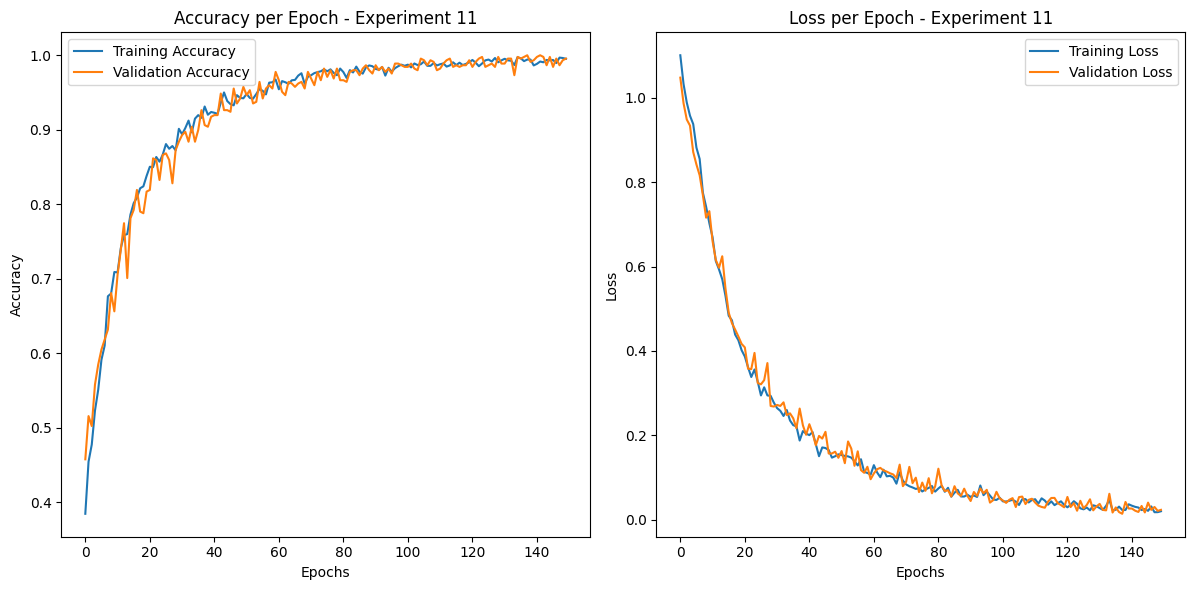

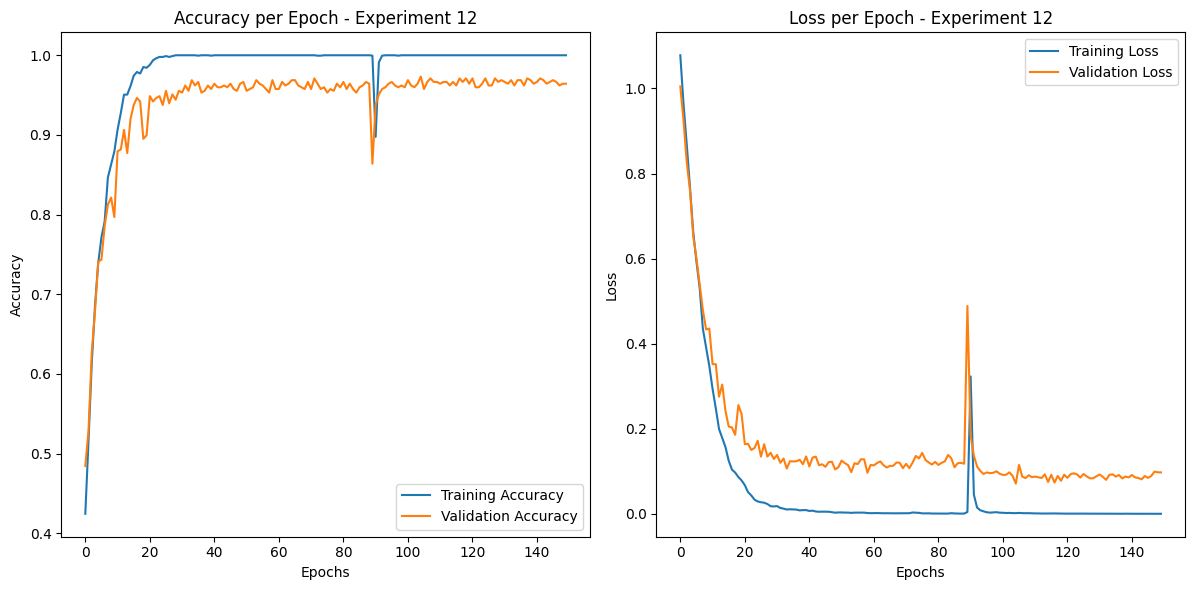

In [7]:
for i, row in results_df.iterrows():
    epoch_data = epoch_results[i]

    plt.figure(figsize=(18, 6))

    # Plot Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epoch_data['accuracy'], label='Training Accuracy')
    plt.plot(epoch_data['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy per Epoch - Experiment {row['experiment']}")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 3, 2)
    plt.plot(epoch_data['loss'], label='Training Loss')
    plt.plot(epoch_data['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Loss per Epoch - Experiment {row['experiment']}")
    plt.legend()


    plt.tight_layout()
    plt.show()

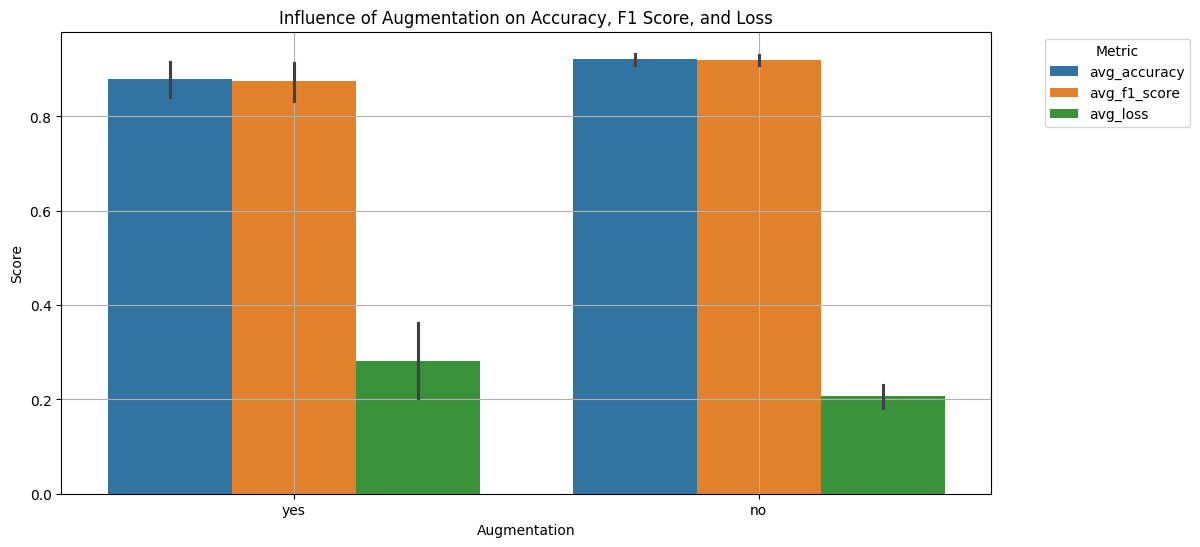

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame with the results
results_long = pd.melt(results_df, id_vars=['epochs', 'dropout', 'img_size', 'augmentation'],
                       value_vars=['avg_accuracy', 'avg_f1_score', 'avg_loss'],
                       var_name='metric', value_name='score')

# Plot Influence of Augmentation on Accuracy, F1 Score, and Loss
plt.figure(figsize=(12, 6))
sns.barplot(x='augmentation', y='score', hue='metric', data=results_long)
plt.xlabel('Augmentation')
plt.ylabel('Score')
plt.title('Influence of Augmentation on Accuracy, F1 Score, and Loss')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

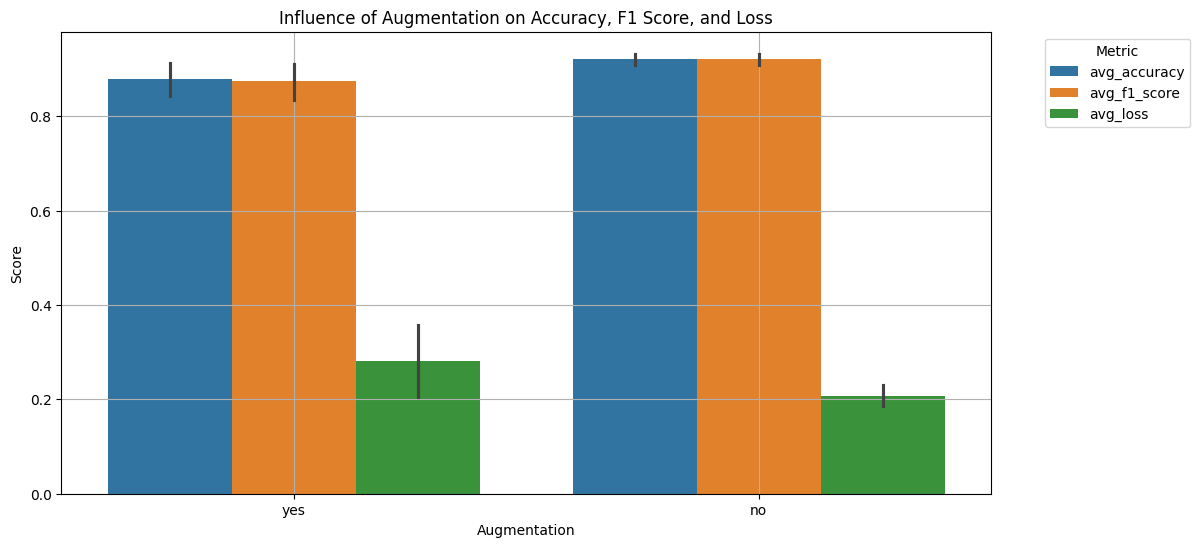

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame with the results
results_long = pd.melt(results_df, id_vars=['epochs', 'dropout', 'img_size', 'augmentation'],
                       value_vars=['avg_accuracy', 'avg_f1_score', 'avg_loss'],
                       var_name='metric', value_name='score')

# Plot Influence of Augmentation on Accuracy, F1 Score, and Loss
plt.figure(figsize=(12, 6))
sns.barplot(x='augmentation', y='score', hue='metric', data=results_long)
plt.xlabel('Augmentation')
plt.ylabel('Score')
plt.title('Influence of Augmentation on Accuracy, F1 Score, and Loss')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

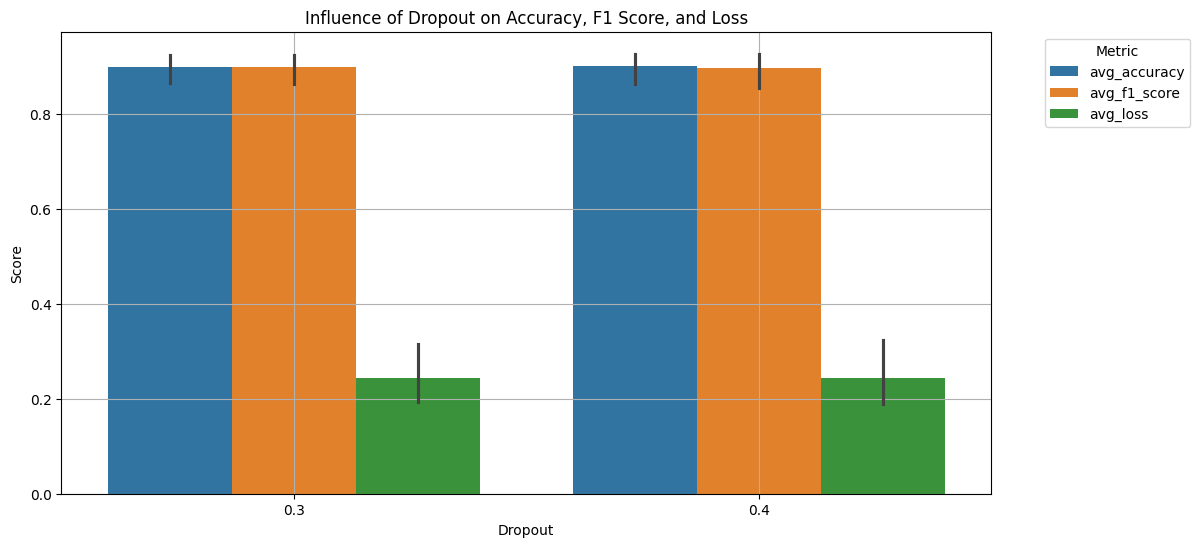

In [10]:
# Plot Influence of Dropout on Accuracy, F1 Score, and Loss
plt.figure(figsize=(12, 6))
sns.barplot(x='dropout', y='score', hue='metric', data=results_long)
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Influence of Dropout on Accuracy, F1 Score, and Loss')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

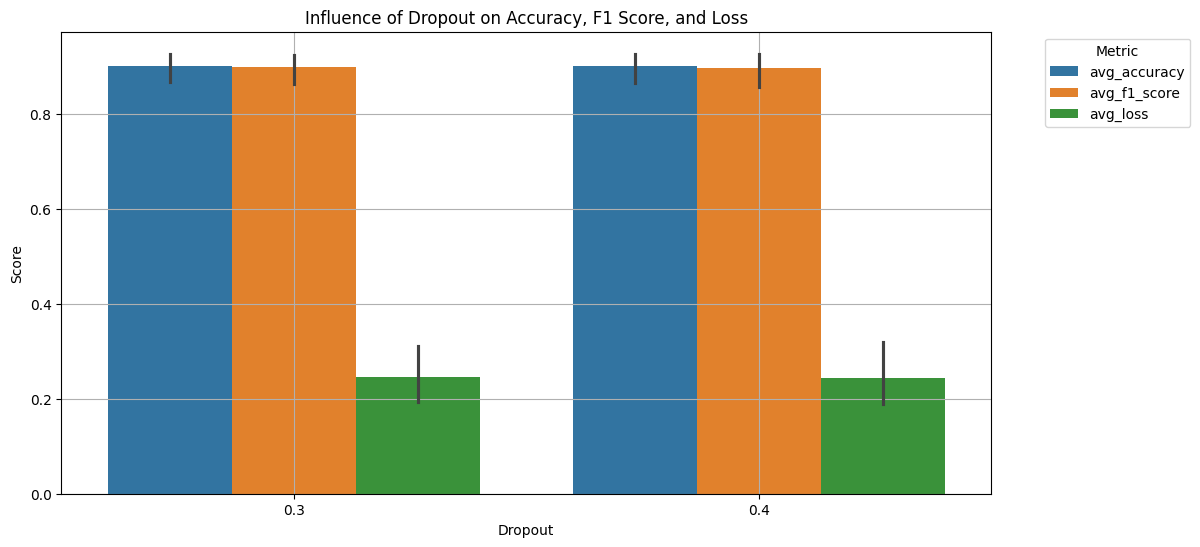

In [11]:
# Plot Influence of Dropout on Accuracy, F1 Score, and Loss
plt.figure(figsize=(12, 6))
sns.barplot(x='dropout', y='score', hue='metric', data=results_long)
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Influence of Dropout on Accuracy, F1 Score, and Loss')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [12]:
import numpy as np
import pandas as pd

# Assuming results and epoch_results are available from the previous code

def analyze_stability_and_overfitting(epoch_data):
    """
    Analyze the stability and overfitting/underfitting of training and validation metrics.
    Return True if the metrics are stable and not overfit/underfit, otherwise False.
    """
    accuracy = np.array(epoch_data['accuracy'])
    val_accuracy = np.array(epoch_data['val_accuracy'])
    loss = np.array(epoch_data['loss'])
    val_loss = np.array(epoch_data['val_loss'])
    f1 = np.array(epoch_data['f1'])

    # Check stability over the last 10 epochs
    stable_epochs = 10
    if len(accuracy) >= stable_epochs:
        last_accuracy = accuracy[-stable_epochs:]
        last_val_accuracy = val_accuracy[-stable_epochs:]
        last_loss = loss[-stable_epochs:]
        last_val_loss = val_loss[-stable_epochs:]

        acc_diff = np.abs(last_accuracy - last_val_accuracy).mean()
        loss_diff = np.abs(last_loss - last_val_loss).mean()
        f1_acc_diff = np.abs(last_accuracy - f1[-stable_epochs:]).mean()

        # Define thresholds for stability
        stability_threshold = 0.05
        if acc_diff < stability_threshold and loss_diff < stability_threshold and f1_acc_diff < stability_threshold:
            return True
    return False

def check_overfitting(accuracy, val_accuracy, loss, val_loss):
    """
    Check if the model is overfitting or underfitting.
    """
    acc_diff = np.abs(np.array(accuracy) - np.array(val_accuracy)).mean()
    loss_diff = np.abs(np.array(loss) - np.array(val_loss)).mean()

    overfit_threshold = 0.1  # Set an appropriate threshold for overfitting
    if acc_diff < overfit_threshold and loss_diff < overfit_threshold:
        return True
    return False

# Analyzing the results
optimal_results = []
for result, epoch_data in zip(results, epoch_results):
    if analyze_stability_and_overfitting(epoch_data) and check_overfitting(epoch_data['accuracy'], epoch_data['val_accuracy'], epoch_data['loss'], epoch_data['val_loss']):
        result['stability'] = True
        optimal_results.append(result)
    else:
        result['stability'] = False

optimal_results_df = pd.DataFrame(optimal_results)

# If there are stable results, find the best based on average accuracy, F1 score, and loss
if not optimal_results_df.empty:
    best_accuracy = optimal_results_df.loc[optimal_results_df['avg_accuracy'].idxmax()]
    best_f1_score = optimal_results_df.loc[optimal_results_df['avg_f1_score'].idxmax()]
    best_loss = optimal_results_df.loc[optimal_results_df['avg_loss'].idxmin()]

    print("Best Stable Parameters Based on Accuracy:")
    print(f"Epochs: {best_accuracy['epochs']}, Dropout: {best_accuracy['dropout']}, Augmentation: {best_accuracy['augmentation']}")
    print(best_accuracy)

    print("\nBest Stable Parameters Based on F1 Score:")
    print(f"Epochs: {best_f1_score['epochs']}, Dropout: {best_f1_score['dropout']}, Augmentation: {best_f1_score['augmentation']}")
    print(best_f1_score)

    print("\nBest Stable Parameters Based on Loss:")
    print(f"Epochs: {best_loss['epochs']}, Dropout: {best_loss['dropout']}, Augmentation: {best_loss['augmentation']}")
    print(best_loss)
else:
    print("No stable parameters found based on the given criteria.")


Best Stable Parameters Based on Accuracy:
Epochs: 150, Dropout: 0.3, Augmentation: yes
experiment             9
augmentation         yes
epochs               150
img_size         128x128
dropout              0.3
avg_accuracy    0.929583
avg_loss        0.173567
avg_f1_score    0.928556
stability           True
Name: 4, dtype: object

Best Stable Parameters Based on F1 Score:
Epochs: 150, Dropout: 0.3, Augmentation: yes
experiment             9
augmentation         yes
epochs               150
img_size         128x128
dropout              0.3
avg_accuracy    0.929583
avg_loss        0.173567
avg_f1_score    0.928556
stability           True
Name: 4, dtype: object

Best Stable Parameters Based on Loss:
Epochs: 150, Dropout: 0.3, Augmentation: yes
experiment             9
augmentation         yes
epochs               150
img_size         128x128
dropout              0.3
avg_accuracy    0.929583
avg_loss        0.173567
avg_f1_score    0.928556
stability           True
Name: 4, dtype: obje

Found 1968 images belonging to 3 classes.
Found 492 images belonging to 3 classes.
Epoch 1/150
16/16 [==============================] - 1s 28ms/step

Epoch 1: F1 Score = 0.34443665823586217
30/30 [==============================] - 14s 433ms/step - loss: 1.0825 - accuracy: 0.3734 - val_loss: 1.0575 - val_accuracy: 0.4040
Epoch 2/150
16/16 [==============================] - 0s 27ms/step

Epoch 2: F1 Score = 0.4643245988681673
30/30 [==============================] - 13s 415ms/step - loss: 1.0327 - accuracy: 0.4443 - val_loss: 0.9983 - val_accuracy: 0.4665
Epoch 3/150
16/16 [==============================] - 0s 26ms/step

Epoch 3: F1 Score = 0.5749184047542281
30/30 [==============================] - 13s 423ms/step - loss: 0.9684 - accuracy: 0.5063 - val_loss: 0.9704 - val_accuracy: 0.5424
Epoch 4/150
16/16 [==============================] - 1s 26ms/step

Epoch 4: F1 Score = 0.5913621915510568
30/30 [==============================] - 13s 421ms/step - loss: 0.9170 - accuracy: 0.5693 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


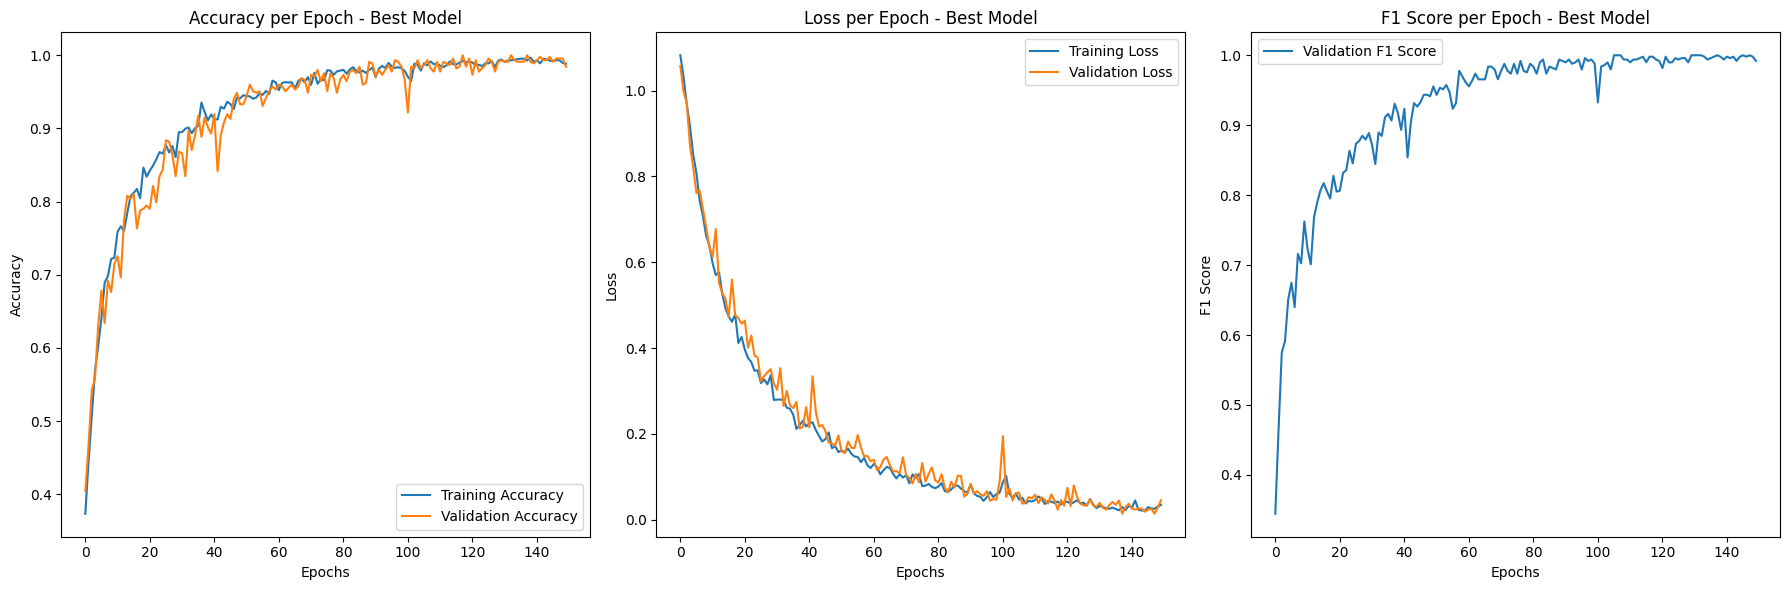

In [35]:
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

# Define the best parameters
best_epochs = 150
best_dropout = 0.4
best_img_size = (128, 128)
best_augmentation = True

# Define global variables
data_dir = 'Dataset Katarak/train'
BATCH_SIZE = 64  # adjustable

# Function to create and compile the model
def create_model(dropout_rate, img_size):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    return model

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        val_true = np.argmax(val_labels, axis=1)
        f1 = f1_score(val_true, val_pred, average='weighted')
        self.f1_scores.append(f1)
        print(f"\nEpoch {epoch + 1}: F1 Score = {f1}")

# Function to train and evaluate the model
def train_and_evaluate(epochs, dropout, img_size, augmentation):
    # Define data augmentation options
    if augmentation:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )

    # Generators for training and validation
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # Create and compile the model
    model = create_model(dropout, img_size)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Prepare validation data for callback
    val_data = np.concatenate([validation_generator[i][0] for i in range(len(validation_generator))])
    val_labels = np.concatenate([validation_generator[i][1] for i in range(len(validation_generator))])

    # Initialize F1 score callback
    f1_callback = F1ScoreCallback(validation_data=(val_data, val_labels))

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=epochs,
        callbacks=[f1_callback]
    )

    # Save the model
    model.save('best_cataract_model.h5')

    return history, f1_callback.f1_scores

# Train and evaluate using the best parameters
history, f1_scores = train_and_evaluate(best_epochs, best_dropout, best_img_size, best_augmentation)

# Plot the results
plt.figure(figsize=(18, 6))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f"Accuracy per Epoch - Best Model")
plt.legend()

# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f"Loss per Epoch - Best Model")
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title(f"F1 Score per Epoch - Best Model")
plt.legend()

plt.tight_layout()
plt.show()


# Testing

Found 450 images belonging to 3 classes.
8/8 [==============================] - 1s 61ms/step


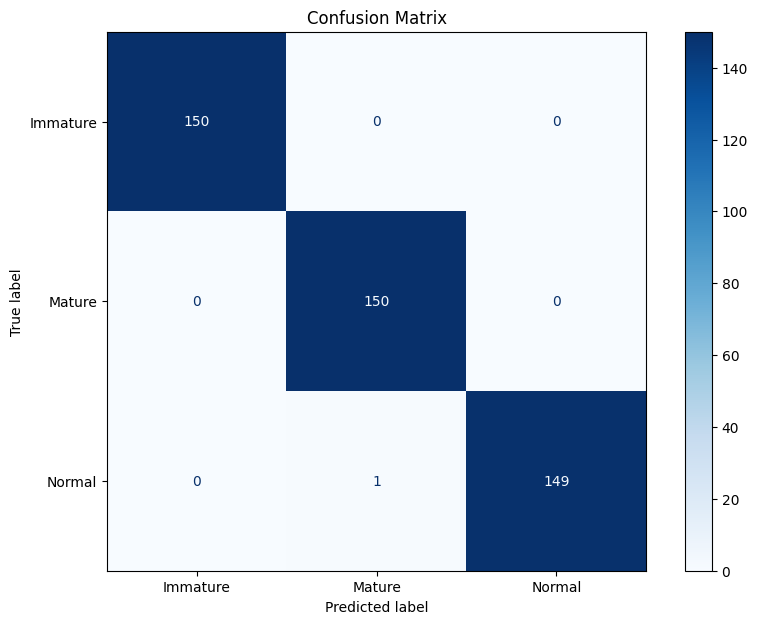

Classification Report:
               precision    recall  f1-score   support

    Immature       1.00      1.00      1.00       150
      Mature       0.99      1.00      1.00       150
      Normal       1.00      0.99      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Results DataFrame:


,file_name,true_class,predicted_class,correct,prediction_probabilities
0,Immature/aug_0_1010_jpeg.rf.299bb9938c97ea011d...,Immature,Immature,True,"[0.97917485, 1.3518379e-05, 0.020811602]"
1,Immature/aug_0_1012_jpeg.rf.37e31f96a29ce5a68d...,Immature,Immature,True,"[0.9920323, 0.0012556348, 0.006711994]"
2,Immature/aug_0_1156_jpeg.rf.ff8950ee5178b7620b...,Immature,Immature,True,"[0.9978886, 0.0021108245, 5.6272944e-07]"
3,Immature/aug_0_1166_jpeg.rf.6125272d377e504352...,Immature,Immature,True,"[0.9918002, 0.0030752986, 0.0051244344]"
4,Immature/aug_0_1327_jpeg.rf.5e4686fa4f26a4d0e0...,Immature,Immature,True,"[0.99936455, 0.0005445143, 9.093921e-05]"
...,...,...,...,...,...
445,Normal/aug_0_9426_jpeg.rf.c12a78e3e89470c488c2...,Normal,Normal,True,"[7.548807e-10, 1.060993e-09, 0.99999994]"
446,Normal/aug_0_9573_jpeg.rf.236a53e001bad9ccde64...,Normal,Normal,True,"[3.1959488e-07, 3.3522588e-07, 0.99999934]"
447,Normal/aug_0_9680_jpeg.rf.29d1d3008ed5db92d3bb...,Normal,Normal,True,"[6.7164547e-06, 3.28602e-07, 0.9999929]"
448,Normal/aug_0_9726_jpeg.rf.e1620070f885dd6fd87e...,Normal,Normal,True,"[1.6199029e-12, 2.0209274e-14, 1.0]"


In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import display

# Define global variables
test_data_dir = 'Dataset Katarak/test'
BATCH_SIZE = 64
IMG_SIZE = (128, 128)

# Load the best model
model = load_model('best_cataract_model.h5')

# Define data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get the filenames, true labels, and predict labels
filenames = test_generator.filenames
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Make predictions
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Determine if the predictions are correct
correct_predictions = pred_labels == true_labels

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'file_name': filenames,
    'true_class': [class_names[true] for true in true_labels],
    'predicted_class': [class_names[pred] for pred in pred_labels],
    'correct': correct_predictions,
    'prediction_probabilities': list(pred_probs)
})

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix with red colormap
plt.figure(figsize=(10, 7))
cm_display.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))

# Display the results DataFrame in Google Colab
print("Results DataFrame:")
display(results_df)

# Save the results DataFrame to a CSV file
results_df.to_csv('test_results.csv', index=False)
